# 라이브러리 불러오기

In [1]:
from data.load_dataset import load_dataset
from data.merge_dataset import merge_dataset
from data.feature_engineering import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import folium

# 데이터 불러오기

In [2]:
# 기존 데이터 불러오기
train_data, test_data, sample_submission, interest_data, subway_data, school_data, park_data = load_dataset()

# 기존 데이터에 새로운 feature들을 병합한 데이터프레임 불러오기
train_data, test_data = merge_dataset(train_data, test_data, interest_data, subway_data, school_data, park_data)

In [3]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,nearest_school_longitude,nearest_park_distance,nearest_park_latitude,nearest_park_longitude,nearest_subway_num,nearest_school_num,nearest_park_num,num_of_subways_within_radius,num_of_schools_within_radius,num_of_parks_within_radius
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,127.046337,498.618918,37.051333,127.041019,1,1,1,0,2,2
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,127.046337,498.618918,37.051333,127.041019,1,1,1,0,2,2
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,127.046337,498.618918,37.051333,127.041019,1,1,1,0,2,2
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,127.056980,169.839678,36.963502,127.054582,1,1,1,0,4,8
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,127.085154,382.401815,36.971743,127.088742,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,...,126.657114,398.113485,37.528189,126.654891,1,1,1,0,4,2
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,...,126.657114,398.113485,37.528189,126.654891,1,1,1,0,4,2
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,...,126.657114,398.113485,37.528189,126.654891,1,1,1,0,4,2
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,...,126.657114,398.113485,37.528189,126.654891,1,1,1,0,4,2


In [4]:
test_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,nearest_school_longitude,nearest_park_distance,nearest_park_latitude,nearest_park_longitude,nearest_subway_num,nearest_school_num,nearest_park_num,num_of_subways_within_radius,num_of_schools_within_radius,num_of_parks_within_radius
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8,...,127.056980,288.442840,36.964653,127.045679,1,1,1,0,0,7
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27,...,127.056980,153.733042,36.961730,127.040502,1,1,1,0,0,5
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,...,127.051762,272.286038,36.959505,127.047945,1,1,1,0,0,4
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34,...,127.051762,272.286038,36.959505,127.047945,1,1,1,0,0,4
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34,...,127.051762,272.286038,36.959505,127.047945,1,1,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,...,126.657114,398.113485,37.528189,126.654891,1,1,1,0,4,2
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,...,126.657114,398.113485,37.528189,126.654891,1,1,1,0,4,2
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,...,126.657114,398.113485,37.528189,126.654891,1,1,1,0,4,2
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,...,126.657114,398.113485,37.528189,126.654891,1,1,1,0,4,2


## 파생변수 EDA

In [ ]:
# # 반경 내 공공장소 수-전세가 상자그림 시각화 (train data)
# fig, axes = plt.subplots(2, 3, figsize=(15, 5))
# sns.boxplot(x="num_of_subways_within_radius", y="deposit", data=train_data, ax=axes[0, 0])
# sns.boxplot(x="num_of_school_within_radius", y="deposit", data=train_data, ax=axes[0, 1])
# sns.boxplot(x="num_of_park_within_radius", y="deposit", data=train_data, ax=axes[0, 2])
# sns.boxplot(x="num_of_subways_within_radius", y="deposit", data=train_data, ax=axes[1, 0])
# sns.boxplot(x="num_of_school_within_radius", y="deposit", data=train_data, ax=axes[1, 1])
# sns.boxplot(x="num_of_park_within_radius", y="deposit", data=train_data, ax=axes[1, 2])
# plt.show()

In [ ]:
# # 반경 내 공공장소 수 히스토그램 시각화 (train data)
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# sns.histplot(x="num_of_subways_within_radius", data=train_data, ax=axes[0])
# sns.histplot(x="num_of_schools_within_radius", data=train_data, ax=axes[1])
# sns.histplot(x="num_of_parks_within_radius", data=train_data, ax=axes[2])
# plt.show()

In [ ]:
# # 반경 내 공공장소 수 히스토그램 시각화 (train data)
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# sns.histplot(x="num_of_subways_within_radius", data=train_data, ax=axes[0])
# sns.histplot(x="num_of_schools_within_radius", data=train_data, ax=axes[1])
# sns.histplot(x="num_of_parks_within_radius", data=train_data, ax=axes[2])
# plt.show()

## 클러스터링

### 시도 1. 클러스터링에 거리와 관련된 변수를 모두 사용한다.

- `latitude`
- `longitude`
- `nearest_subway_distance`
- `nearest_school_distance`
- `nearest_park_distance`
- `num_of_subways_within_radius`
- `num_of_schools_within_radius`
- `num_of_parks_within_radius`

In [ ]:
# 클러스터링에 이용할 변수 선택: 거리와 관련된 변수
feature_columns = [
	"latitude",
	"longitude",
	"nearest_subway_distance",
	"nearest_school_distance",
	"nearest_park_distance",
	"num_of_subways_within_radius",
	"num_of_schools_within_radius",
	"num_of_parks_within_radius"
]

coords = train_data[feature_columns]

# 클러스터링 객체 생성
cm = ClusteringModel(data=coords)

# 클러스터 개수 설정: k=20
n_clusters = cm.find_kmeans_n_clusters(max_clusters=30)

# k-means 클러스터링 수행 후 train_data, test_data에 cluster 변수 추가
kmeans = cm.kmeans_clustering(n_clusters, train_data, test_data, 
							  feature_columns, 
							  label_column="region"
)


### 시도 2. 클러스터링에 거리와 관련된 변수 중 위,경도와 최단거리만 사용한다.

- `latitude`
- `longitude`
- `nearest_subway_distance`
- `nearest_school_distance`
- `nearest_park_distance`

In [ ]:
# 클러스터링에 이용할 변수 선택: 거리와 관련된 변수
feature_columns = [
	"latitude",
	"longitude",
	"nearest_subway_distance",
	"nearest_school_distance",
	"nearest_park_distance"
]

coords = train_data[feature_columns]

# 클러스터링 객체 생성
cm = ClusteringModel(data=coords)

# 클러스터 개수 설정: k=20
n_clusters = cm.find_kmeans_n_clusters(max_clusters=30)

# k-means 클러스터링 수행 후 train_data, test_data에 cluster 변수 추가
kmeans = cm.kmeans_clustering(n_clusters, train_data, test_data, 
							  feature_columns, 
							  label_column="region"
)


### 시도 3. 클러스터링에 거리와 관련된 변수 중 위,경도와 반경 내 개수만 사용한다.

- `latitude`
- `longitude`
- `num_of_subways_within_radius`
- `num_of_schools_within_radius`
- `num_of_parks_within_radius`

In [ ]:
# 클러스터링에 이용할 변수 선택: 거리와 관련된 변수
feature_columns = [
	"latitude",
	"longitude",
	"num_of_subways_within_radius",
	"num_of_schools_within_radius",
	"num_of_parks_within_radius"
]

coords = train_data[feature_columns]

# 클러스터링 객체 생성
cm = ClusteringModel(data=coords)

# 클러스터 개수 설정: k=20
n_clusters = cm.find_kmeans_n_clusters(max_clusters=30)

# k-means 클러스터링 수행 후 train_data, test_data에 cluster 변수 추가
kmeans = cm.kmeans_clustering(n_clusters, train_data, test_data, 
							  feature_columns, 
							  label_column="region"
)


### 시도 4. 클러스터링에 위,경도만 사용한다.

- `latitude`
- `longitude`

Elbow Method 진행 중...⏳: 100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


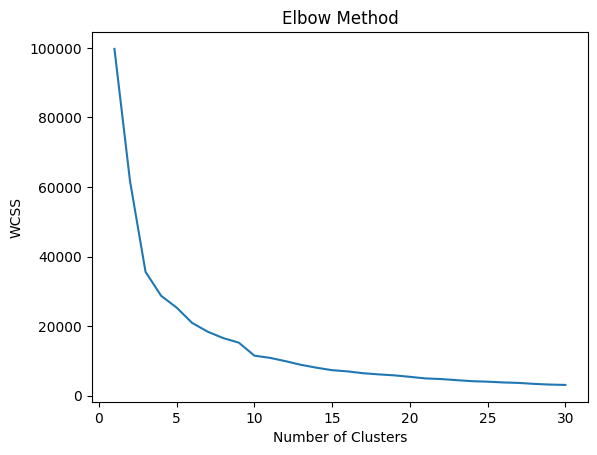

KMeans Optimal_clusters: 30


In [5]:
# 클러스터링에 이용할 변수 선택: 거리와 관련된 변수
feature_columns = [
	"latitude",
	"longitude"
]

coords = train_data[feature_columns]

# 클러스터링 객체 생성
cm = ClusteringModel(data=coords)

# 클러스터 개수(k) 설정
n_clusters = cm.find_kmeans_n_clusters(max_clusters=30)
# k-means 클러스터링 수행 후 train_data, test_data에 cluster 변수 추가
kmeans = cm.kmeans_clustering(n_clusters, train_data, test_data, 
							  feature_columns, 
							  label_column="region"
)

### 클러스터링 결과 시각화

In [6]:
def visualize_by_region(data: pd.DataFrame) -> object:
    # 기본 지도 설정 (초기 중심점은 데이터의 평균 위도와 경도로 설정)
    center_lat = data["latitude"].mean()
    center_lon = data["longitude"].mean()
    map_folium = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # 고유한 지역 목록 가져오기
    regions = data["region"].unique()

    # 색상 매핑: 고유한 지역마다 색상을 할당
    cmap = plt.get_cmap("inferno", len(regions))
    norm = colors.Normalize(vmin=0, vmax=len(regions)-1)
    region_colors = {region: colors.to_hex(cmap(norm(i))) for i, region in enumerate(regions)}

    # 지역별로 지도에 마커 추가
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=1,
            color=region_colors[row["region"]],
            fill=True,
            fill_color=region_colors[row["region"]],
            fill_opacity=0.7,
            popup=f'Cluster: {row["region"]}\nLatitude: {row["latitude"]}\nLongitude: {row["longitude"]}'
        ).add_to(map_folium)

    return map_folium

In [7]:
map_folium = visualize_by_region(train_data[["latitude", "longitude", "region"]].drop_duplicates().reset_index(drop=True))

## 대장 아파트

### 대장 아파트 데이터프레임 생성

In [8]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,nearest_park_distance,nearest_park_latitude,nearest_park_longitude,nearest_subway_num,nearest_school_num,nearest_park_num,num_of_subways_within_radius,num_of_schools_within_radius,num_of_parks_within_radius,region
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,498.618918,37.051333,127.041019,1,1,1,0,2,2,9
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,498.618918,37.051333,127.041019,1,1,1,0,2,2,9
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,498.618918,37.051333,127.041019,1,1,1,0,2,2,9
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,169.839678,36.963502,127.054582,1,1,1,0,4,8,9
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,382.401815,36.971743,127.088742,1,1,1,0,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,...,398.113485,37.528189,126.654891,1,1,1,0,4,2,21
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,...,398.113485,37.528189,126.654891,1,1,1,0,4,2,21
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,...,398.113485,37.528189,126.654891,1,1,1,0,4,2,21
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,...,398.113485,37.528189,126.654891,1,1,1,0,4,2,21


In [9]:
test_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,nearest_park_distance,nearest_park_latitude,nearest_park_longitude,nearest_subway_num,nearest_school_num,nearest_park_num,num_of_subways_within_radius,num_of_schools_within_radius,num_of_parks_within_radius,region
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8,...,288.442840,36.964653,127.045679,1,1,1,0,0,7,9
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27,...,153.733042,36.961730,127.040502,1,1,1,0,0,5,9
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,...,272.286038,36.959505,127.047945,1,1,1,0,0,4,9
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34,...,272.286038,36.959505,127.047945,1,1,1,0,0,4,9
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34,...,272.286038,36.959505,127.047945,1,1,1,0,0,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,...,398.113485,37.528189,126.654891,1,1,1,0,4,2,21
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,...,398.113485,37.528189,126.654891,1,1,1,0,4,2,21
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,...,398.113485,37.528189,126.654891,1,1,1,0,4,2,21
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,...,398.113485,37.528189,126.654891,1,1,1,0,4,2,21


In [10]:
# train_data 대장 아파트 데이터프레임 생성
max_deposits = train_data.groupby(["region"])["deposit"].max()
leader_train_data = pd.DataFrame()

for i in tqdm(max_deposits.index, desc="계산 중...⏳"):
    # print(i, max_deposits[i])
    tmp = train_data[(train_data["region"] == i) & (train_data["deposit"] == max_deposits[i])][["region", "deposit", "latitude", "longitude"]] 
    # print(tmp) # 거래 건수가 여러 개 존재
    leader_train_data = pd.concat([leader_train_data, tmp], axis=0, ignore_index=True)

leader_train_data = leader_train_data.drop_duplicates().reset_index(drop=True) # 위도, 경도 중복 제거
leader_train_data

계산 중...⏳: 100%|██████████| 30/30 [00:00<00:00, 200.87it/s]


,region,deposit,latitude,longitude
0,0,210000.0,37.428620,126.998875
1,1,280000.0,37.481308,127.095205
2,2,90000.0,37.657762,126.681119
3,3,190000.0,37.292018,127.054198
4,4,350000.0,37.557573,127.163406
5,5,350000.0,37.551046,126.913739
6,6,300000.0,37.526924,126.874494
7,7,100000.0,37.370995,126.727390
8,8,55000.0,37.128714,126.922338
9,8,55000.0,37.127166,126.925577


#### ※ 참고: `test_data`는 `deposit`이 없기 때문에 대장 아파트를 클러스터 내에서 찾을 수 없다.
그래서 train_data의 대장 아파트 정보를 test_data에 그대로 추가해준다.

### 대장 아파트와의 최단거리 계산

In [12]:
# train_data, test_data에서 위도, 경도 중복 행을 제외하고 추출
unique_loc_train: pd.DataFrame = train_data[["latitude", "longitude"]].drop_duplicates().reset_index(drop=True)
unique_loc_test: pd.DataFrame = test_data[["latitude", "longitude"]].drop_duplicates().reset_index(drop=True)

# train_data에 대장 아파트 최단거리 추가
merged_df: pd.DataFrame = find_nearest_haversine_distance(unique_loc_train, leader_train_data)
merged_df: pd.DataFrame = pd.concat([merged_df, unique_loc_train], axis=1)
train_data: pd.DataFrame = pd.merge(train_data, merged_df, on=["latitude", "longitude"], how="left")
train_data.rename(columns={
        "nearest_distance": "nearest_leader_distance",
        "nearest_latitude": "nearest_leader_latitude",
        "nearest_longitude": "nearest_leader_longitude"
        }, 
        inplace=True
)

# test_data에선 대장 아파트를 따로 알 수 없는 거니까 train_data의 대장 아파트를 활용해서 거리 계산을 한다.
merged_df: pd.DataFrame = find_nearest_haversine_distance(unique_loc_test, leader_train_data)
merged_df: pd.DataFrame = pd.concat([merged_df, unique_loc_test], axis=1)
test_data: pd.DataFrame = pd.merge(test_data, merged_df, on=["latitude", "longitude"], how="left")
test_data.rename(columns={
        "nearest_distance": "nearest_leader_distance",
        "nearest_latitude": "nearest_leader_latitude",
        "nearest_longitude": "nearest_leader_longitude"
        }, 
        inplace=True
)

In [13]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,nearest_subway_num,nearest_school_num,nearest_park_num,num_of_subways_within_radius,num_of_schools_within_radius,num_of_parks_within_radius,region,nearest_leader_distance,nearest_leader_latitude,nearest_leader_longitude
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,1,1,1,0,2,2,9,6364.110019,37.016774,127.099337
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,1,1,1,0,2,2,9,6364.110019,37.016774,127.099337
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,1,1,1,0,2,2,9,6364.110019,37.016774,127.099337
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,1,1,1,0,4,8,9,6965.283186,37.016774,127.099337
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,1,1,1,0,0,1,9,5107.786855,37.016774,127.099337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,...,1,1,1,0,4,2,21,1870.242566,37.531248,126.638497
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,...,1,1,1,0,4,2,21,1870.242566,37.531248,126.638497
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,...,1,1,1,0,4,2,21,1870.242566,37.531248,126.638497
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,...,1,1,1,0,4,2,21,1870.242566,37.531248,126.638497


In [14]:
test_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,nearest_subway_num,nearest_school_num,nearest_park_num,num_of_subways_within_radius,num_of_schools_within_radius,num_of_parks_within_radius,region,nearest_leader_distance,nearest_leader_latitude,nearest_leader_longitude
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8,...,1,1,1,0,0,7,9,7263.960558,37.016774,127.099337
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27,...,1,1,1,0,0,5,9,7921.813207,37.016774,127.099337
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,...,1,1,1,0,0,4,9,8079.923658,37.016774,127.099337
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34,...,1,1,1,0,0,4,9,8079.923658,37.016774,127.099337
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34,...,1,1,1,0,0,4,9,8079.923658,37.016774,127.099337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,...,1,1,1,0,4,2,21,1870.242566,37.531248,126.638497
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,...,1,1,1,0,4,2,21,1870.242566,37.531248,126.638497
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,...,1,1,1,0,4,2,21,1870.242566,37.531248,126.638497
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,...,1,1,1,0,4,2,21,1870.242566,37.531248,126.638497


### 대장 아파트와의 최단거리 EDA

In [15]:
# 클러스터별로 지도에 마커 추가: 대장 아파트
for _, row in leader_train_data.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=f'Cluster: {row["region"]}\nLatitude: {row["latitude"]}\nLongitude: {row["longitude"]}', # 마커에 마우스 올렸을 때 나오는 내용
        popup=f'Cluster: {row["region"]}\nCluster: {row["deposit"]}\nLatitude: {row["latitude"]}\nLongitude: {row["longitude"]}', # 마커 클릭시 나오는 내용
        icon=folium.Icon(color = "blue", icon = "home")
    ).add_to(map_folium)

map_folium.save("cluster.html")

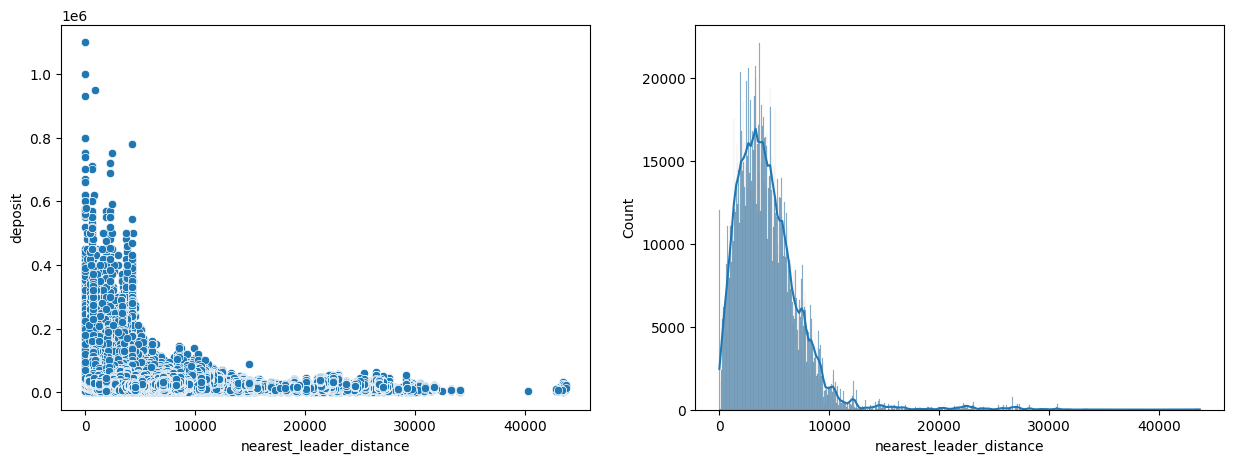

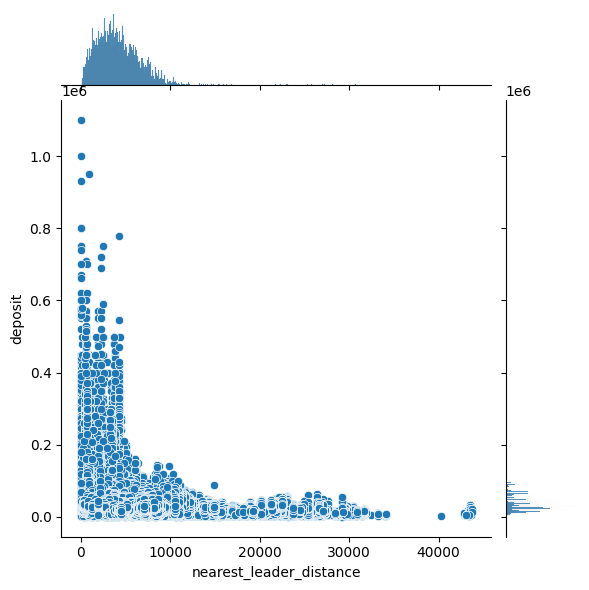

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="nearest_leader_distance", y="deposit", data=train_data, ax=axes[0]) # 대장 아파트와의 최단거리-전세가 산점도 시각화
sns.histplot(x="nearest_leader_distance", data=train_data, ax=axes[1], kde=True) # 대장 아파트와의 최단거리 히스토그램 시각화

# 위 두 그림 합친 버전
sns.jointplot(x="nearest_leader_distance", y="deposit", data=train_data)
plt.show()

각 건물과 대장 아파트와의 최단거리도 오른쪽으로 꼬리가 긴 분포를 보이므로 로그 변환 또는 제곱근 변환을 고려해야 한다.